In [1]:
import pandas as pd
import numpy as np 
import os 
import cv2 
from glob import glob
import torchvision.models as models
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
dir_Flickr_jpg = "../input/d/datasets/nunenuh/flickr8k/images"
dir_Flickr_text = "../input/d/datasets/nunenuh/flickr8k/captions.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [3]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

In [4]:
def load_doc(filename):
    open_file = open(dir_Flickr_text, 'r', encoding='latin-1' ) 
    text = open_file.read() 
    open_file.close()
    return text
doc = load_doc(text)
print(doc[:300])

image_name|caption_number|caption_text
1000268201_693b08cb0e.jpg|0|A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg|1|A girl going into a wooden building .
1000268201_693b08cb0e.jpg|2|A little girl climbing into a wooden playhouse .
1000268201_693b08


In [5]:
all_img_id = [] 
all_img_vector = [] 
annotations = [] 

with open(dir_Flickr_text , 'r') as fo:
  next(fo) 
  for line in fo :
    split_arr = line.split('|')
    all_img_id.append(split_arr[0])
    annotations.append(split_arr[2].rstrip('\n')) #removing out the \n.
    all_img_vector.append(split_arr[1])

In [6]:
df_txt = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['filename','Index', 'caption']) 
uni_filenames = np.unique(df_txt.values)   
df_txt.head(10)

,filename,Index,caption
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,0,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,1,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,2,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,3,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,4,Two dogs on pavement moving toward each other .


# Preprocessing Text

In [7]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame(list(ct.items()), columns=['word', 'count'])
    dfword.sort_values(by='count', ascending=False, inplace=True)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 9656


,word,count
0,a,40318
1,.,36478
2,A,22591


In [8]:
import string

def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)


def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)


def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [9]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

In [10]:
for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

In [11]:
from copy import copy
def add_start_end_seq_token(caption):
    caps = []
    for txt in caption:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [12]:
df_txt0.head()

,filename,Index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...


In [13]:
import tensorflow as tf
modelvgg = tf.keras.applications.VGG16(include_top=True, weights=None)
modelvgg.load_weights("../input/weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

2022-03-20 14:21:21.200486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 14:21:21.201586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 14:21:21.202394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 14:21:21.203382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
modelvgg.layers.pop()
modelvgg = tf.keras.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
modelvgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from tqdm import tqdm



jpgs = os.listdir(dir_Flickr_jpg)
images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(tqdm(jpgs)):
    
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

  0%|          | 0/8091 [00:00<?, ?it/s]2022-03-20 14:21:32.409553: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-20 14:21:33.415289: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 8091/8091 [08:32<00:00, 15.78it/s]


In [16]:
images["1000268201_693b08cb0e.jpg"].shape

(4096,)

In [17]:
len(images)

8091

In [18]:
df_txt0.head()

,filename,Index,caption
0,1000268201_693b08cb0e.jpg,0,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,startseq little girl in pink dress going into...


In [19]:
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["Index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

In [20]:
dimages.shape

(8091, 4096)

In [21]:
dcaptions[:5]

array(['startseq  child in pink dress is climbing up set of stairs in an entry way endseq',
       'startseq  black dog and spotted dog are fighting endseq',
       'startseq  little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
       'startseq  man lays on bench while his dog sits by him endseq',
       'startseq  man in an orange hat starring at something endseq'],
      dtype=object)

In [22]:
from keras.preprocessing.text import Tokenizer

nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)

vocabulary size : 4476


In [23]:
dtexts[:5]

[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2],
 [1, 12, 8, 5, 752, 8, 17, 368, 2],
 [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2],
 [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2],
 [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]

In [24]:
prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [25]:
maxlen = np.max([len(text) for text in dtexts])

In [26]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


In [27]:
Xtext_train[:14]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1,   75],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,   75,   38],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,   75,   38,   33],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1, 

In [28]:
Ximage_train.shape

(49631, 4096)

In [29]:
ytext_train.shape

(49631, 4476)

In [30]:
from tensorflow.keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

## sequence model
input_txt = layers.Input(shape=(maxlen,))
### The embedding layer in Keras can be used when we want to create the embeddings to embed higher dimensional data into lower dimensional vector space.
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)

## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = tf.keras.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       286464      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding[0][0]                  
_______________________________________________________________________________________

In [31]:
print(Ximage_train[0])
print(Xtext_train[0])
print(ytext_train[0][75])

[2.9835725  0.         0.22122577 ... 0.         0.         0.        ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
1.0


In [32]:
import time
start = time.time()

hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
    
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

2022-03-20 14:30:55.923317: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 888593424 exceeds 10% of free system memory.
2022-03-20 14:30:57.401731: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 888593424 exceeds 10% of free system memory.


Epoch 1/5
776/776 - 75s - loss: 5.3321 - val_loss: 4.7822
Epoch 2/5
776/776 - 71s - loss: 4.3503 - val_loss: 4.4902
Epoch 3/5
776/776 - 74s - loss: 3.8892 - val_loss: 4.4209
Epoch 4/5
776/776 - 77s - loss: 3.5773 - val_loss: 4.4653
Epoch 5/5
776/776 - 73s - loss: 3.3112 - val_loss: 4.5377
TIME TOOK 6.20MIN


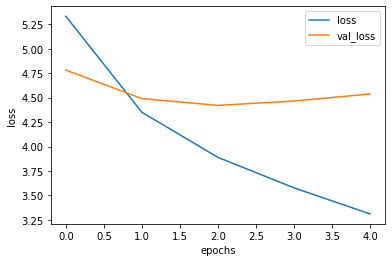

In [33]:
import matplotlib.pyplot as plt 
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

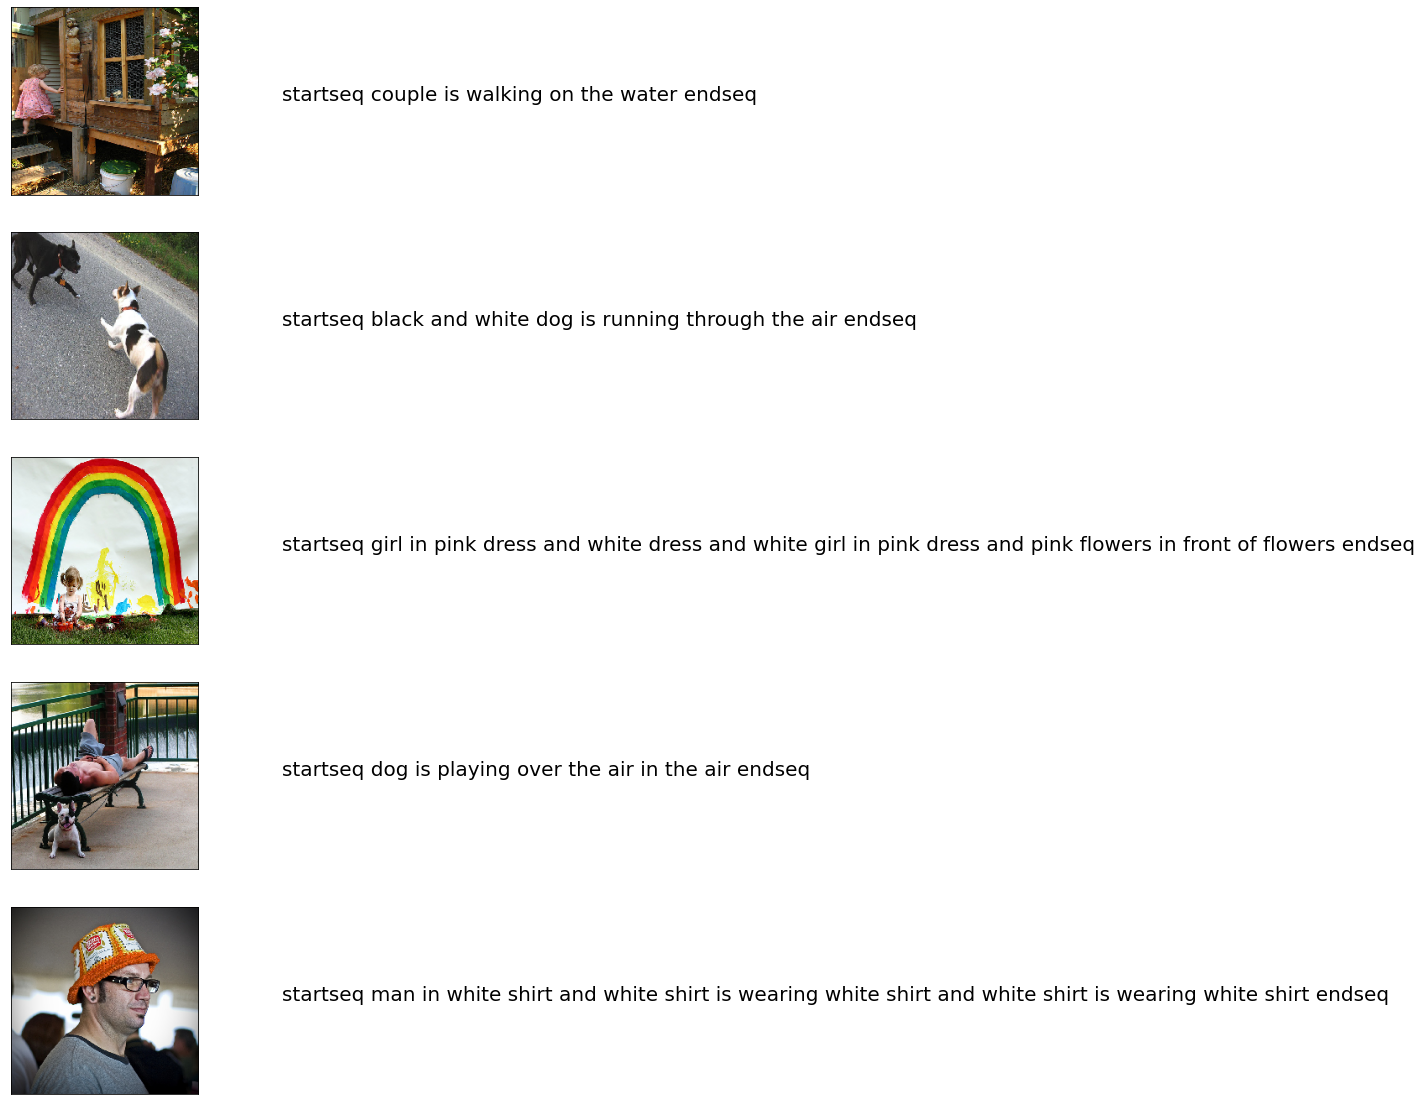

In [34]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()